# AR models

In [50]:
# System
# ================================
import os

# Data import and manipulation
# ================================
import pandas as pd
import numpy as np
import re

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import mean_absolute_percentage_error

# Plots
# ==============================================================================
import seaborn as sn
from matplotlib import pyplot as plt

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [51]:
py_path = re.sub(r"\\", "/", os.environ["PYTHONPATH"])

In [52]:
data = pd.read_csv(py_path + "/Forecasting_Repository/data/processed/processed_data.csv", index_col="time")
data.index = pd.to_datetime(data.index)
data

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,price actual,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_mass,cloud_cover,air_density,Holidays
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,65.41,1.000000e-07,0.451,0.0,0.0,0.0,2.781,0.0868,11.948,1
2015-01-01 01:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,64.92,2.000000e-07,0.234,0.0,0.0,0.0,2.781,0.1135,11.957,1
2015-01-01 02:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,64.48,2.000000e-07,0.129,0.0,0.0,0.0,2.781,0.0127,11.965,1
2015-01-01 03:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,59.32,2.000000e-07,0.008,0.0,0.0,0.0,0.278,0.1154,11.971,1
2015-01-01 04:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,56.04,1.000000e-07,0.042,0.0,0.0,0.0,0.278,0.0984,11.978,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,...,77.02,0.000000e+00,6.908,0.0,0.0,0.0,0.000,0.0305,11.669,0
2018-12-31 20:00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,...,76.16,0.000000e+00,6.164,0.0,0.0,0.0,0.000,0.0338,11.692,0
2018-12-31 21:00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,...,74.30,0.000000e+00,5.575,0.0,0.0,0.0,0.000,0.0408,1.171,0


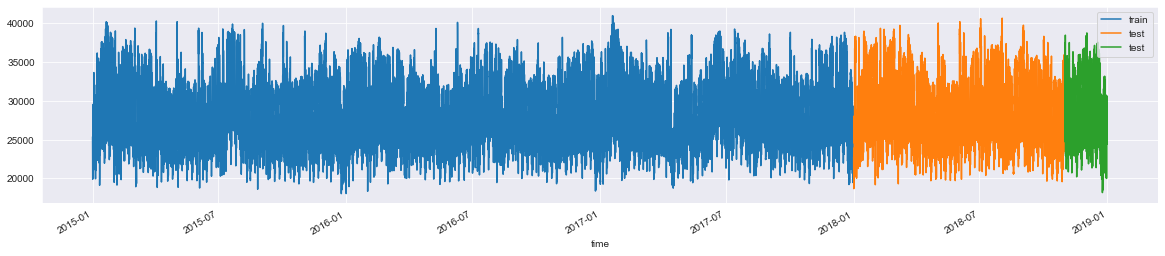

In [53]:
# Split data into train-val-test
# ==============================================================================
end_train = "2017-12-31 23:00:00"
start_validation = "2018-01-01 00:00:00"
end_validation = "2018-10-31 23:00:00"
start_test = "2018-11-01 00:00:00"

data_train = data.loc[: end_train, :]  # tre anni
data_validation = data.loc[start_validation: end_validation, :]  # dieci mesi
data_test = data.loc[start_test:, :]  # due mesi

fig, ax = plt.subplots(figsize=(20, 4))
data_train['total load actual'].plot(ax=ax, label='train')
data_validation['total load actual'].plot(ax=ax, label='test')
data_test['total load actual'].plot(ax=ax, label='test')
ax.legend()

<AxesSubplot:xlabel='total load actual'>

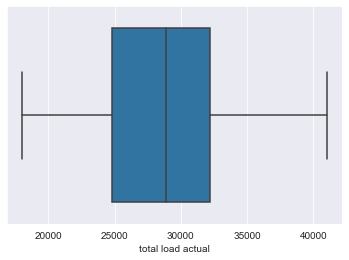

In [54]:
sn.boxplot(data["total load actual"])

Non si notano outliers quindi l'eventuale scalatura dei dati può corrispondere a un semplice StandardScaler()

---
---
## 2. MODELLING
Dato che non è stata riscontrata la presenza di un *trend* inizio l'analisi con un semplice modello AR

---
### 2.1 AR model
Dati i valori del PACF per la variabile total load actual assegno un p = 24 che corrisponde a 24 ore
Probabilmente sarà necessaria l'aggiunta di variabili dummy e della componente stagionale settimanale / giornaliera

In [55]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor=make_pipeline(StandardScaler(), Ridge()),
    lags=24  # lag di un giorno
)

forecaster.fit(y=data.loc[:end_validation, 'total load actual'])
forecaster

KeyboardInterrupt: 

In [ ]:
# Backtest
# ==============================================================================
metric, predictions = backtesting_forecaster(forecaster=forecaster,
                                             y=data['total load actual'],
                                             initial_train_size=len(data.loc[:end_validation]),
                                             fixed_train_size=False,
                                             steps=24,
                                             metric='mean_absolute_error',
                                             refit=True,
                                             verbose=True)

print(f'Backtest error: {metric}')

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor=make_pipeline(StandardScaler(), Ridge()),
    lags=24  # This value will be replaced in the grid search
)

# Lags used as predictors
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'ridge__alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(forecaster=forecaster,
                                      y=data.loc[:end_validation, 'total load actual'],
                                      param_grid=param_grid,
                                      lags_grid=lags_grid,
                                      steps=24,
                                      metric='mean_absolute_error',
                                      refit=False,
                                      initial_train_size=len(data[:end_train]),
                                      fixed_train_size=False,
                                      return_best=True,
                                      verbose=False)

In [ ]:
results_grid

Il miglior modello risulta essere quello che considera i lags [1, 2, 3, 23, 24, 25, 47, 48, 49] e utilizza un alpha pari a 0.001 per la Ridge regression

In [ ]:
# Modello restituito dalla Grid-Search
forecaster

In [ ]:
# Backtest final model
# ==============================================================================
""" MAE metric """

mae, predictions = backtesting_forecaster(forecaster=forecaster,  # forecaster fatto dalla best grid
                                          y=data['total load actual'],
                                          initial_train_size=len(data[:end_validation]),
                                          fixed_train_size=False,
                                          steps=24,
                                          metric='mean_absolute_error',
                                          refit=True,
                                          verbose=False
                                          )

# Test error
# ==============================================================================
mape = mean_absolute_percentage_error(
                y_true = data_test['total load actual'][:1488],
                y_pred = predictions
            )

print(f"Test error (mape): {mape}")
print(f"Test error (mae): {mae}")

I risultati non sono male.

In [ ]:
predictions.index

In [ ]:
# Fix prediction dataframe
predictions = predictions.assign(time=data[start_test:].index)
predictions = predictions.set_index("time")
predictions

In [ ]:
month_before_data = data.index[len(data) - len(predictions) * 2 + 24:len(data) - len(predictions)]  # date dal 1 novembre al 31 dicembre

In [ ]:
fig, ax = plt.subplots(figsize=(30, 3))
data['total load actual'][month_before_data].plot(linewidth=2, ax=ax, label="month_before_data")  # 1 month before
data['total load actual'][min(predictions.index):max(predictions.index)].plot(linewidth=2, ax=ax, label="real")  # real
predictions['pred'].plot(linewidth=2, ax=ax, label="predictions")  # predicted
ax.set_title('Prediction vs real demand')
plt.legend(["1 month before", "real values", "predicted"])

---
### 2.2 Analisi dei residui
Dato che nella costruzione del modello AR si suppone che gli **errori** si distribuiscano come una **normale** e che questi abbiano una **varianza costante**, è fondamentale fare delle analisi che ci permettano di accertare queste due ipotesi in modo da poter verificare l'attendibilità dei risultati.

In [ ]:
predictions

Identifichiamo i residui e aggiungiamoli al dataframe contenente le previsioni

In [ ]:
residuals = []
for ind in predictions["pred"].index:
    predicted_value = predictions['pred'][ind]
    real_value = data['total load actual'][ind]
    residuals.append(predicted_value - real_value)

print(residuals[:10])

In [ ]:
# Aggiunta colonna al dataframe con le previsioni
predictions["residuals"] = residuals
predictions

#### 2.2.1 Distribuzione dei residui

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
sn.histplot(data=predictions, x="residuals", kde=True)
plt.title("Residual distribution")

I residui si distribuiscono come una normale

#### 2.2.2 Test per eteroschedasticità

In [ ]:
g = sn.lmplot(data=predictions, x="pred", y="residuals", height=5, aspect=5, order=2)

g.axes[0][0].axhline(y=0, ls = "--", alpha=0.4)

plt.title("Residuals Vs Predicted Values")
plt.show()

L'andamento è lineare. E' bene però fare un test per accertarsi dell'entità dell' eteroschedasticità(varianza non costante nei termini di errore)

In [ ]:
def test_model(col):
    final_array = []
    for value in col:
        a = [1, value]
        final_array.append(a)
    return np.array(final_array)

model = test_model(data_test["total load actual"])  # array dei valori reali di Y

In [ ]:
# Breusch-Pagan Lagrange Multiplier test for heteroscedasticity
# ==============================================================================
""" It tests the hypothesis that the residual variance does not depend on the variables in x in the form """

bp_test = het_breuschpagan(predictions["residuals"], model)

print(f"LM-test p_value: {bp_test[1]}")

Il valore del P value è molto basso. In questo caso, rifiutiamo l'ipotesi nulla quindi è presente eteroschedasticità.
Proviamo a scalare la y tramite una radice quadrata, questo dovrebbe ridurre il peso delle osservazioni con valori estremi riducendo quindi l'impatto dei loro residui nella distribuzione.

### 2.3 Abbattimento eteroschedasticità

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor=make_pipeline(StandardScaler(), Ridge()),
    lags=24  # This value will be replaced in the grid search
)

# Lags used as predictors
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'ridge__alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(forecaster=forecaster,
                                      y=np.sqrt(data.loc[:end_validation, 'total load actual']),
                                      param_grid=param_grid,
                                      lags_grid=lags_grid,
                                      steps=24,
                                      metric='mean_absolute_error',
                                      refit=False,
                                      initial_train_size=len(data[:end_train]),
                                      fixed_train_size=False,
                                      return_best=True,
                                      verbose=False)

# Backtest final model
# ==============================================================================
""" MAE metric """

mae, predictions = backtesting_forecaster(forecaster=forecaster,  # forecaster fatto dalla best grid
                                          y=np.sqrt(data['total load actual']),
                                          initial_train_size=len(data[:end_validation]),
                                          fixed_train_size=False,
                                          steps=24,
                                          metric='mean_absolute_error',
                                          refit=True,
                                          verbose=False
                                          )

# Test error
# ==============================================================================
mape = mean_absolute_percentage_error(
                y_true = np.sqrt(data_test['total load actual'][:1488]),
                y_pred = predictions
            )

print(f"Test error (mape): {mape}")
print(f"Test error (mae): {mae}")

In [ ]:
# Fix prediction dataframe
predictions = predictions.assign(time=data[start_test:].index)
predictions = predictions.set_index("time")
predictions

In [ ]:
# Plot risultati
fig, ax = plt.subplots(figsize=(30, 2.5))
np.sqrt(data['total load actual'][month_before_data]).plot(linewidth=2, ax=ax, label="month_before_data")  # 1 month before
np.sqrt(data['total load actual'][min(predictions.index):max(predictions.index)]).plot(linewidth=2, ax=ax, label="real")  # real
predictions['pred'].plot(linewidth=2, ax=ax, label="predictions")  # predicted
ax.set_title('Prediction vs real demand')
plt.legend(["1 month before", "real values", "predicted"])

In [ ]:
# Calcolo residui
residuals = []
for ind in predictions["pred"].index:
    predicted_value = predictions['pred'][ind]
    real_value = np.sqrt(data['total load actual'][ind])
    residuals.append(predicted_value - real_value)

# Aggiunta colonna al dataframe con le previsioni
predictions["residuals"] = residuals
predictions

#### 2.3.1 Test per eteroschedasticità

In [ ]:
g = sn.lmplot(data=predictions, x="pred", y="residuals", height=5, aspect=5, order=2)

g.axes[0][0].axhline(y=0, ls = "--", alpha=0.4)

plt.title("Residuals Vs Predicted Values")
plt.show()

In [ ]:
def test_model(col):
    final_array = []
    for value in col:
        a = [1, value]
        final_array.append(a)
    return np.array(final_array)

model = test_model(np.sqrt(data_test["total load actual"]))  # array dei valori reali di Y

In [ ]:
# Breusch-Pagan Lagrange Multiplier test for heteroscedasticity
# ==============================================================================
""" It tests the hypothesis that the residual variance does not depend on the variables in x in the form """

bp_test = het_breuschpagan(predictions["residuals"], model)

print(f"LM-test p_value: {bp_test[1]}")

**Eteroschedasticità eliminata**

##### Dall'analisi dei residui possiamo confermare le ipotesi di base di un modello AR riguardo gli errori e di conseguenza anche la veridicità dei risultati dello stesso.

---
### 2.3 AR aggiungendo variabili esogene

In [ ]:
data.iloc[:, 20:]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forecaster = ForecasterAutoreg(
    regressor=make_pipeline(StandardScaler(), Ridge()),
    lags=24  # This value will be replaced in the grid search
)

# Lags used as predictors
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'ridge__alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(
                                      forecaster         = forecaster,
                                      y                  = data.loc[:end_validation, 'total load actual'],
                                      exog               = data.iloc[:, 20:][:end_validation],  # variabili meteorologiche
                                      param_grid         = param_grid,
                                      lags_grid          = lags_grid,
                                      steps              = 744,  # un mese in ore
                                      metric             = 'mean_absolute_error',
                                      refit              = True,
                                      initial_train_size = len(data[:end_train]),
                                      fixed_train_size   = False,
                                      return_best        = True,
                                      verbose            = False)

# Backtest final model
# ==============================================================================
""" MAE metric """

mae, predictions = backtesting_forecaster(forecaster=forecaster,  # forecaster fatto dalla best grid
                                          y=data['total load actual'],
                                          exog=data.iloc[:, 20:],
                                          initial_train_size=len(data[:end_validation]),
                                          fixed_train_size=False,
                                          steps=744,
                                          metric='mean_absolute_error',
                                          refit=True,
                                          verbose=False
                                          )

# Test error
# ==============================================================================
mape = mean_absolute_percentage_error(
                y_true = data_test['total load actual'][:744],
                y_pred = predictions
            )

print(f"Test error (mape): {mape}")
print(f"Test error (mae): {mae}")

**I risultati sono peggiorati.**
C'è comunque da considerare il fatto che stiamo usando un AR e non stiamo tenendo conto della stagionalità

In [ ]:
predictions

In [ ]:
predictions = predictions.assign(time=data.index[len(data) - len(predictions):])
predictions.set_index("time", inplace=True)
predictions

In [ ]:
residuals = []
for ind in predictions["pred"].index:
    predicted_value = predictions['pred'][ind]
    real_value = data['total load actual'][ind]
    residuals.append(predicted_value - real_value)

print(residuals[:10])

In [ ]:
# Aggiunta colonna al dataframe con le previsioni
predictions["residuals"] = residuals
predictions

In [ ]:
# Test error
# ==============================================================================
mape = mean_absolute_percentage_error(
                y_true = data_test['total load actual'][:744],
                y_pred = predictions["pred"]
            )

print(f"MAE: {mae}\nMAPE: {mape}")

In [ ]:
fig, ax = plt.subplots(figsize=(30, 3))
data['total load actual'][month_before_data].plot(linewidth=2, ax=ax, label="month_before_data")  # 1 month before
data['total load actual'][min(predictions.index):max(predictions.index)].plot(linewidth=2, ax=ax, label="real")  # real
predictions['pred'].plot(linewidth=2, ax=ax, label="predictions")  # predicted
ax.set_title('Prediction vs real demand')
plt.legend(["1 month before", "real values", "predicted"])

Anche il grafico mostra il netto peggioramento

#### Analizziamo i residui

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
sn.histplot(data=predictions, x="residuals", kde=True)
plt.title("Residual distribution")

Distribuzione degli errori non buona

In [ ]:
#### 2.2.2 Test per eteroschedasticità
g = sn.lmplot(data=predictions, x="pred", y="residuals", height=5, aspect=5, order=2)

g.axes[0][0].axhline(y=0, ls="--", alpha=0.4)

plt.title("Residuals Vs Predicted Values")
plt.show()

L'andamento non è troppo variabile ma comunque gli errori si distribuiscono in maniera non costante dallo zero. Probabilmente è presente eteroschedasticità

In [ ]:
def test_model(col):
    final_array = []
    for value in col:
        a = [1, value]
        final_array.append(a)
    return np.array(final_array)

In [ ]:
model = test_model(data_test["total load actual"])  # array dei valori reali di Y
# Breusch-Pagan Lagrange Multiplier test for heteroscedasticity
# ==============================================================================
""" It tests the hypothesis that the residual variance does not depend on the variables in x in the form """

bp_test = het_breuschpagan(predictions["residuals"], model)

print(f"LM-test p_value: {bp_test[1]}")

Eteroschedasticità confermata